In [1]:
# Yonghwan Kim A11746276
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import collections
import copy
import math

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# directory to the input file
youtube_edgelist_dir = '/content/drive/MyDrive/Project5/YouTube.edgelist'
twenty_percent_seed_communities_dir = '/content/drive/MyDrive/Project5/20percent_seed_communities.txt'
neighborhood_seeds_dir = '/content/drive/MyDrive/Project5/neighborhood_seeds.txt'
groundtruth_communities_dir = '/content/drive/MyDrive/Project5/groundtruth_communities.txt'

In [4]:
graph = nx.read_edgelist(youtube_edgelist_dir, nodetype=int) # create undirected graph using youtube edgelist
print(f'Is graph directed? {nx.is_directed(graph)}')
print(f'graph: nodes {len(graph.nodes)}, edges {len(graph.edges)}') # graph nodes and edges

Is graph directed? False
graph: nodes 7675, edges 35622


In [5]:
# read ground truth community data for later evaluation
ground_truth_dict = dict()

# Open ground truth community file
with open(groundtruth_communities_dir) as gtdr:
    lines = gtdr.readlines()
    com_count_g = 0

    for line in lines:
        if com_count_g not in ground_truth_dict:
            ground_truth_dict[com_count_g] = []
        nodes = line.split()
        for n in nodes:
            ground_truth_dict[com_count_g].append(int(n))
        com_count_g = com_count_g + 1

In [6]:
# number of communities
K = 29
# V * K, non-negative Factor Matrix, 20% seed initialization
F_twenty_seed = np.zeros((len(graph.nodes), K))
# V * K, non-negative Factor Matrix, Neighborhood seed initialization
F_neighbor_seed = np.zeros((len(graph.nodes), K))
# V * K, non-negative Factor Matrix, Random seed initialization
F_random = np.random.rand(len(graph.nodes), K)

twenty_seed_dict = dict()
# create pass list
twenty_seed_node_pass_list = []
# Open 20% seed file
with open(twenty_percent_seed_communities_dir) as tpsc:
    lines = tpsc.readlines()
    com_count = 0
    for line in lines:
        if com_count not in twenty_seed_dict:
            twenty_seed_dict[com_count] = []
        nodes = line.split()
        for n in nodes:
            twenty_seed_dict[com_count].append(int(n))
            node_temp = int(n)
            # set the given data 1 in F matrix
            F_twenty_seed[node_temp][com_count] = 1
            twenty_seed_node_pass_list.append(node_temp)
        com_count = com_count + 1

neighbor_seed_dict = dict()
# create pass list
neighbor_seed_node_pass_list = []
# Open Neighborhood seed file
with open(neighborhood_seeds_dir) as nsd:
    lines = nsd.readlines()
    com_count = 0
    for line in lines:
        if com_count not in neighbor_seed_dict:
            neighbor_seed_dict[com_count] = []
        nodes = line.split()
        for n in nodes:
            neighbor_seed_dict[com_count].append(int(n))
            node_temp = int(n)
            # set the given data 1 in F matrix
            F_neighbor_seed[node_temp][com_count] = 1
            neighbor_seed_node_pass_list.append(node_temp)
        com_count = com_count + 1

In [7]:
# F matrix initialization function
# parameter: graph, F matrix, pass list, seed type, node number, community number
def mat_init(G, F, passList, seed_dict, node_num, comm_num):
    temp_F = copy.deepcopy(F)
    # travesed list to skip traversed nodes
    travesedList = []

    for r in range(node_num): # node
        if r in travesedList:
            continue
        # guard to check pass list
        guard = True
        if r in passList:
            guard = False

        if guard:
            # calculate conductance level to initialize F matrix
            conductanceLevel = [] # conductance list
            for k in range(comm_num): # community
                tempList = copy.deepcopy(seed_dict[k])
                tempList.append(r) # node u
                tempList.extend(list(G.neighbors(r))) # node u's neighbors
                conductanceLevel.append(nx.conductance(G, tempList)) # conductance

            min_val = min(conductanceLevel) # locally minimum 
            min_index = conductanceLevel.index(min_val)
            # assign 1 if locally minimum
            temp_F[r][min_index] = 1
            # assign 1 to u's neighbor if u is locally minimum
            for neighbor in list(G.neighbors(r)):
                temp_F[neighbor][min_index] = 1

            travesedList.append(r)
    return temp_F

# Twenty seed F matrix initialization
F_twenty_seed = copy.deepcopy(mat_init(graph, F_twenty_seed, twenty_seed_node_pass_list, twenty_seed_dict, len(graph.nodes), K))
# Neighbor seed F matrix initialization
F_neighbor_seed = copy.deepcopy(mat_init(graph, F_neighbor_seed, neighbor_seed_node_pass_list, neighbor_seed_dict, len(graph.nodes), K)) 

In [8]:
# F matrix factorization function
# parameter: graph, F matrix, node number, community number, learning rate
def mat_factorization(G, F, node_num, comm_num, learningRate):
    final_F = copy.deepcopy(F)
    # number of iteration
    iter = 500
    prv_sum = 0
    cr_sum = 0
    # list for second plot later
    update_rate = dict()
    # 500 iteration
    for itr in range(iter):
        # compute gradient delta L(Fu)
        temp_F = copy.deepcopy(final_F)
        # caching Fw
        sum_Fw = np.zeros((comm_num,))
        # calculate Fw / updating Fw every iteration
        for n in range(node_num):
            sum_Fw += temp_F[n]
        
        for n in range(node_num): # node
            # bigclamv2.0 algorithm
            neighb = list(G.neighbors(n))
            sum_Fv = np.zeros((comm_num,))
            sum_neigh = np.zeros((comm_num,))
            for nb in neighb:
                # Fu * Fv.transepose
                fu_fvt = np.dot(temp_F[n], temp_F[nb].transpose())
                s1 = np.exp(-1.0 * fu_fvt)
                s2 = 1 - np.exp(-1.0 * fu_fvt)
                if s1 != 0 and s2 != 0:
                    sum_neigh += temp_F[nb] * np.divide(s1, s2)
                sum_Fv += temp_F[nb]
            # V2.0 to calculate Fv faster
            sum_none_neigh = sum_Fw - temp_F[n] - sum_Fv
            # delta L(Fu)
            gradient_u = sum_neigh - sum_none_neigh
            # update Fu values
            temp_F[n] += learningRate * gradient_u
            # update to non-negative
            temp_F[n] = np.where(temp_F[n] < 0, 0, temp_F[n])

        prv_sum = np.sum(final_F)
        cr_sum = np.sum(temp_F)
        # list for second plot later
        update_rate[itr] = prv_sum / cr_sum * 100
        final_F = copy.deepcopy(temp_F)
        # Stop iterations either you reach I iterations or if the increase of Fu is less than 0.001% for all Fu
        if prv_sum > cr_sum:
            if cr_sum / prv_sum * 100 < 0.001:
                print(iter)
                break
        if cr_sum > prv_sum:
            if prv_sum / cr_sum * 100 < 0.001:
                print(iter)
                break
    return (final_F, update_rate)

In [9]:
# Twenty seed factorization
tws = mat_factorization(graph, F_twenty_seed, len(graph.nodes), K, 0.0001)

In [10]:
# Neighbor seed factorization
ns = mat_factorization(graph, F_neighbor_seed, len(graph.nodes), K, 0.00001)

In [11]:
# Random seed factorization
rnd = mat_factorization(graph, F_random, len(graph.nodes), K, 0.00001)

In [13]:
# Threshold for community assignment
threshold_delta = math.sqrt(-1 * np.log(1 - (10 ** -8)))

In [14]:
# Save Twenty seed F matrix into file
F_twenty_seed_temp_copy = copy.deepcopy(tws[0])

# community assignment
for n_index in range(len(graph.nodes)):
    for c_index in range(K):
        if F_twenty_seed_temp_copy[n_index][c_index] >= threshold_delta:
            F_twenty_seed_temp_copy[n_index][c_index] = 1
        else:
            F_twenty_seed_temp_copy[n_index][c_index] = 0
# community prediction
com_predict_t = dict()
for k_index in range(K):
    if k_index not in com_predict_t:
        com_predict_t[k_index] = []
# write into file
for n_index in range(len(graph.nodes)):
    for c_index in range(K):
        if F_twenty_seed_temp_copy[n_index][c_index] == 1:
            com_predict_t[c_index].append(n_index)
textfile1 = open("/content/drive/MyDrive/Project5/20seed.txt", "w")

for k_index in range(K):
    for element in com_predict_t[k_index]:
        textfile1.write(str(element) + " ")
    textfile1.write("\n")

textfile1.close()

In [15]:
# Save Neighborhood seed F matrix into file
F_neighbor_seed_temp_copy = copy.deepcopy(ns[0])

# community assignment
for n_index in range(len(graph.nodes)):
    for c_index in range(K):
        if F_neighbor_seed_temp_copy[n_index][c_index] >= threshold_delta:
            F_neighbor_seed_temp_copy[n_index][c_index] = 1
        else:
            F_neighbor_seed_temp_copy[n_index][c_index] = 0
# community prediction
com_predict_n = dict()
for k_index in range(K):
    if k_index not in com_predict_n:
        com_predict_n[k_index] = []
# write into file
for n_index in range(len(graph.nodes)):
    for c_index in range(K):
        if F_neighbor_seed_temp_copy[n_index][c_index] == 1:
            com_predict_n[c_index].append(n_index)
textfile2 = open("/content/drive/MyDrive/Project5/neighbor.txt", "w")

for k_index in range(K):
    for element in com_predict_n[k_index]:
        textfile2.write(str(element) + " ")
    textfile2.write("\n")

textfile2.close()

In [16]:
# Save Random seed F matrix into file
F_random_temp_copy = copy.deepcopy(rnd[0])

# community assignment
for n_index in range(len(graph.nodes)):
    for c_index in range(K):
        if F_random_temp_copy[n_index][c_index] >= threshold_delta:
            F_random_temp_copy[n_index][c_index] = 1
        else:
            F_random_temp_copy[n_index][c_index] = 0
# community prediction
com_predict_r = dict()
for k_index in range(K):
    if k_index not in com_predict_r:
        com_predict_r[k_index] = []
# write into file
for n_index in range(len(graph.nodes)):
    for c_index in range(K):
        if F_random_temp_copy[n_index][c_index] == 1:
            com_predict_r[c_index].append(n_index)
textfile3 = open("/content/drive/MyDrive/Project5/random.txt", "w")

for k_index in range(K):
    for element in com_predict_r[k_index]:
        textfile3.write(str(element) + " ")
    textfile3.write("\n")

textfile3.close()

In [17]:
# recall function to calculate recall(C*, C^)
def recall(gt_list, pr_list):
    set_gt_list = set(gt_list)
    set_pr_list = set(pr_list)
    # # of true positive
    true_positive = len(set_gt_list.intersection(set_pr_list))
    true_positive_plus_false_negative = len(gt_list)
    return true_positive/true_positive_plus_false_negative
# recall function to calculate recall score
def recall_score(gt, cp, c_size):
    best_matching_com_list = []
    # finding best matching community
    for k1 in range(c_size):
        best_matching_com = 0
        nodeLen = 0
        for k2 in range(c_size):
            temp_set1 = set(gt[k1])
            temp_set2 = set(cp[k2])
            matching_len = len(temp_set1.intersection(temp_set2))
            if matching_len > nodeLen:
                best_matching_com = k2
                nodeLen = matching_len
        best_matching_com_list.append((k1, best_matching_com))
    # calculate the recall score of ground truth community and the best matching community prediction
    sum_recall = 0
    for bmc in best_matching_com_list:
        rc = recall(gt[bmc[0]], cp[bmc[1]])
        sum_recall = sum_recall + rc

    recall_score = sum_recall / c_size
    return recall_score

In [49]:
# recall score for 20% seed
recall_score_20seed = recall_score(ground_truth_dict, com_predict_t, K)
# recall score for neighborhood seed
recall_score_neighb = recall_score(ground_truth_dict, com_predict_n, K)
# recall score for 2random seed
recall_score_random = recall_score(ground_truth_dict, com_predict_r, K)

print(f'20% Seed Recall Score: {recall_score_20seed}')
print(f'Neighborhood Seed Recall Score: {recall_score_neighb}')
print(f'Random Seed Recall Score: {recall_score_random}')

20% Seed Recall Score: 0.8438959301195209
Neighborhood Seed Recall Score: 0.781598806156333
Random Seed Recall Score: 0.8136978981593308


# 20% Seed Recall Score: 0.8438959301195209
# Neighborhood Seed Recall Score: 0.781598806156333
# Random Seed Recall Score: 0.8136978981593308

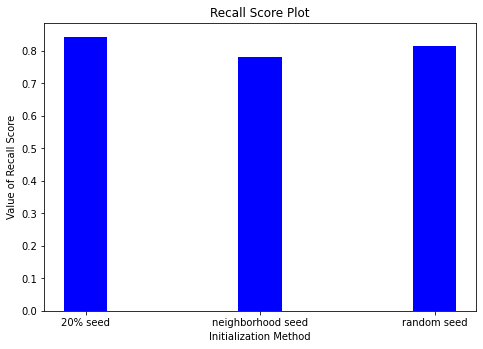

In [52]:
# bar plot to represent the difference of recall scores for each initializatio method
fig = plt.figure()

ax = fig.add_axes([0,0,1,1])

seed_method = ['20% seed', 'neighborhood seed', 'random seed']
recall_data = [recall_score_20seed, recall_score_neighb, recall_score_random]
# draw bars
ax.bar(seed_method, recall_data, color = 'b', width = 0.25)
# plot title
plt.title("Recall Score Plot")
# plot y label
plt.ylabel("Value of Recall Score")
# plot x label
plt.xlabel("Initialization Method")
plt.show()

# The recall score using the 20% seed initialization is the highest.
# Random seed initialization method has different recall score every time it is excuted but my last result had even better result than neighborhood seed initialization.
# The recall score using neighborhood seed initialization method had the lowest of all other method in my last trial though it is still very close to other score.

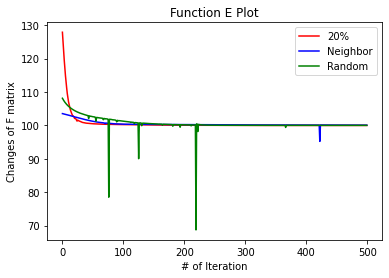

In [51]:
# plot of the changes of F matrix on every iteration
t = range(0, 500)
plt.plot(t, list(tws[1].values()), color='r', label='20%')
plt.plot(t, list(ns[1].values()), color='b', label='Neighbor')
plt.plot(t, list(rnd[1].values()), color='g', label='Random')
# show legend
plt.legend()
# plot title
plt.title("Function E Plot")
# plot y label
plt.ylabel("Changes of F matrix")
# plot x label
plt.xlabel("# of Iteration")

plt.show()

# The above graph shows the changes of F matrix on every iteration.
# It indicates that the amount of changes are decreasing every iteration and converging to the point somewhat close to 100. It also shows that the 20% seed initialization is the most stable and random seed initialization is the least stable method on interation.